In [1]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
import itertools
from tqdm import tqdm

import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
from glob import glob
import time, datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
%load_ext tensorboard

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

from helper_functions import plot_compare_history, plot_confusion_matrix, plot_history_curves, plot_random_image
from helper_functions import create_checkpoint_callback, create_early_stopping_callback, create_reduce_lr_callback, create_tensorboard_callback

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


In [2]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [3]:
train_101_100_dir = './Food-Vision-REDO/datasets/food_101/train/'
train_101_50_dir = './Food-Vision-REDO/datasets/food_101/train_50/'
train_101_20_dir = './Food-Vision-REDO/datasets/food_101/train_20/'
train_101_10_dir = './Food-Vision-REDO/datasets/food_101/train_10/'
test_101_dir = './Food-Vision-REDO/datasets/food_101/test/'
food_101_dir = './Food-Vision-REDO/datasets/food_101/'

In [4]:
checkpoint_path = './Food-Vision-REDO/checkpoint/'
tensorboard_path = './Food-Vision-REDO/transfer_learning/'

earlystopping_callback = create_early_stopping_callback(
    metric='val_accuracy',
    patience=3
)

checkpoint_callback = create_checkpoint_callback(
    checkpoint_path=checkpoint_path,
    metric='val_loss',
    save_best=True
)

lr_callback = create_reduce_lr_callback(
    metric="val_loss",
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-7
)


In [5]:
IMG_SIZE=(224,224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_10_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
).prefetch(tf.data.AUTOTUNE)

train_data_20_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_20_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
).prefetch(tf.data.AUTOTUNE)

train_data_50_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_50_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
).prefetch(tf.data.AUTOTUNE)

train_data_100_percent = tf.keras.preprocessing.image_dataset_from_directory(
    train_101_100_dir,
    label_mode='categorical',
    image_size=IMG_SIZE
).prefetch(tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_101_dir,
    label_mode='categorical',
    image_size=IMG_SIZE,
    shuffle=False
).prefetch(tf.data.AUTOTUNE)

Found 7575 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.
Found 37875 files belonging to 101 classes.
Found 75750 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [6]:
class_list_all = glob(os.path.join(test_101_dir, '*',))
class_list_all = [i.split('\\')[-1] for i in class_list_all]
class_list_all;
len(class_list_all)

101

### Building Different Models and Trying to Improve them

#### Model 0 

**Experiment** - Model 0  
**Data** - 20% of the data set  
**Preprocessing** - None  
**Model** - Feature Extraction of a Transfer Learning Model  

In [21]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE+(3,), name='input_layer')
#x = data_augmentation()
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
x = tf.keras.layers.Dense(len(class_list_all), name='dense_layer')(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])



In [22]:
model_0_history = model_0.fit(
    train_data_100_percent,
    epochs=5,
    steps_per_epoch=len(train_data_100_percent),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[checkpoint_callback, create_tensorboard_callback(
        dir_name=tensorboard_path,
        experiment_name='efficientnetb4_101_data_extraction')]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/efficientnetb4_101_data_extraction/20211117-154405
Epoch 1/5
2368/2368 [==============================] - 123s 48ms/step - loss: 1.7594 - accuracy: 0.5696 - val_loss: 1.6306 - val_accuracy: 0.5784
Epoch 2/5
2368/2368 [==============================] - 112s 47ms/step - loss: 1.2338 - accuracy: 0.6788 - val_loss: 1.4972 - val_accuracy: 0.6128
Epoch 3/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.0854 - accuracy: 0.7158INFO:tensorflow:Assets written to: ./Food-Vision-REDO/checkpoint\assets


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 173s 73ms/step - loss: 1.0853 - accuracy: 0.7158 - val_loss: 1.4757 - val_accuracy: 0.6155
Epoch 4/5
2367/2368 [============================>.] - ETA: 0s - loss: 0.9886 - accuracy: 0.7412INFO:tensorflow:Assets written to: ./Food-Vision-REDO/checkpoint\assets


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 174s 73ms/step - loss: 0.9886 - accuracy: 0.7411 - val_loss: 1.4656 - val_accuracy: 0.6192
Epoch 5/5
2367/2368 [============================>.] - ETA: 0s - loss: 0.9168 - accuracy: 0.7590INFO:tensorflow:Assets written to: ./Food-Vision-REDO/checkpoint\assets


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 174s 73ms/step - loss: 0.9168 - accuracy: 0.7590 - val_loss: 1.4233 - val_accuracy: 0.6314


In [23]:
model_0_evaluation = model_0.evaluate(test_data)

790/790 [==============================] - 34s 42ms/step - loss: 1.2910 - accuracy: 0.6682


In [27]:
cloned_model = tf.keras.models.clone_model(model_0)

In [28]:
cloned_model.load_weights(checkpoint_path)

In [29]:
cloned_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

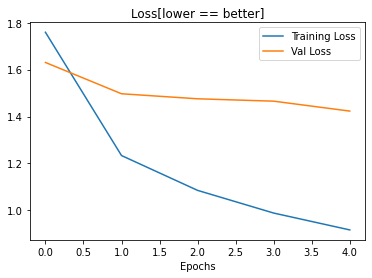

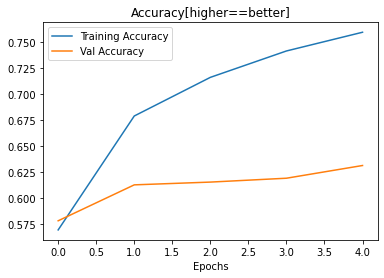

In [24]:
plot_history_curves(model_0_history)

In [31]:
save_dir = "07_efficientnetb0_feature_extract_model_mixed_precision"
model_0.save(save_dir)

INFO:tensorflow:Assets written to: 07_efficientnetb0_feature_extract_model_mixed_precision\assets


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [43]:
loaded_saved_model = tf.keras.models.load_model(save_dir)

In [44]:
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 44s 54ms/step - loss: 1.2910 - accuracy: 0.6682


[1.2909963130950928, 0.6681584119796753]

In [45]:
for layer in loaded_saved_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 True float32 <Policy "mixed_float16">
global_avg_pooling True float32 <Policy "mixed_float16">
dense_layer True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "float32">


In [46]:
loaded_saved_model.compile(loss="categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [47]:
history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data_100_percent,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data_100_percent),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[
                                                            lr_callback,
                                                            earlystopping_callback,
                                                            checkpoint_callback, 
                                                            create_tensorboard_callback(
                                                                dir_name=tensorboard_path,
                                                                experiment_name='efficientnetb4_101_data_extraction')])

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/efficientnetb4_101_data_extraction/20211117-163313
Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.8020 - accuracy: 0.7804INFO:tensorflow:Assets written to: ./Food-Vision-REDO/checkpoint\assets


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2368/2368 [==============================] - 459s 188ms/step - loss: 0.8020 - accuracy: 0.7804 - val_loss: 1.0789 - val_accuracy: 0.7283 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 374s 158ms/step - loss: 0.4653 - accuracy: 0.8710 - val_loss: 1.2001 - val_accuracy: 0.7161 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.2405 - accuracy: 0.9322
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 374s 158ms/step - loss: 0.2405 - accuracy: 0.9322 - val_loss: 1.4030 - val_accuracy: 0.7121 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 372s 157ms/step - loss: 0.0707 - accuracy: 0.9816 - val_loss: 1.5966 - val_accuracy: 0.7251 - lr: 2.0000e-05


In [48]:
loaded_saved_model.evaluate(test_data)

790/790 [==============================] - 36s 46ms/step - loss: 1.4027 - accuracy: 0.7485


[1.4026633501052856, 0.7485148310661316]

In [49]:
loaded_saved_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")


INFO:tensorflow:Assets written to: 07_efficientnetb0_fine_tuned_101_classes_mixed_precision\assets


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


#### Model 1

------------

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomZoom(0.2)
    #tf.keras.layers.Rescaling(1./255), # no need for Effnet
])

In [33]:
checkpoint_path = './Food-Vision-REDO/checkpoint/'

In [34]:
base_model = tf.keras.applications.EfficientNetB4(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE+(3,), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling')(x)
x = tf.keras.layers.Dense(len(class_list_all), name='dense_layer')(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='output_layer')(x)

model_0 = tf.keras.Model(inputs, outputs)

model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])


In [35]:
checkpoint_callback = create_checkpoint_callback(
    checkpoint_path=checkpoint_path,
    metric='val_loss',
    save_best=True,
    save_weights=True
)

In [36]:
model_0_history = model_0.fit(
    train_data_100_percent,
    epochs=5,
    steps_per_epoch=len(train_data_100_percent),
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[checkpoint_callback, 
               create_tensorboard_callback(
                   dir_name=tensorboard_path,
                   experiment_name='efficientnetb4_101_data_extraction_augmented')]
)

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/efficientnetb4_101_data_extraction_augmented/20211117-191837


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
2368/2368 [==============================] - 143s 57ms/step - loss: 2.1850 - accuracy: 0.4750 - val_loss: 1.7288 - val_accuracy: 0.5691
Epoch 2/5
2368/2368 [==============================] - 132s 56ms/step - loss: 1.6958 - accuracy: 0.5688 - val_loss: 1.5499 - val_accuracy: 0.5985
Epoch 3/5
2368/2368 [==============================] - 135s 57ms/step - loss: 1.5768 - accuracy: 0.5955 - val_loss: 1.5248 - val_accuracy: 0.6073
Epoch 4/5
2368/2368 [==============================] - 134s 56ms/step - loss: 1.5072 - accuracy: 0.6102 - val_loss: 1.4777 - val_accuracy: 0.6194
Epoch 5/5
2368/2368 [==============================] - 137s 58ms/step - loss: 1.4534 - accuracy: 0.6222 - val_loss: 1.4812 - val_accuracy: 0.6197


In [37]:
model_0.evaluate(test_data)

790/790 [==============================] - 50s 63ms/step - loss: 1.4443 - accuracy: 0.6251


[1.4443165063858032, 0.6250693202018738]

In [38]:
cloned_model = tf.keras.models.clone_model(model_0)

C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [43]:
cloned_model.load_weights(checkpoint_path)

In [42]:
cloned_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['accuracy'])


In [44]:
cloned_model.evaluate(test_data)

790/790 [==============================] - 39s 47ms/step - loss: 1.9802 - accuracy: 0.4982


[1.9802073240280151, 0.4982178211212158]

In [45]:
for layer in cloned_model.layers:
  layer.trainable = True # set all layers to trainable
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)
  
cloned_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                     optimizer=tf.keras.optimizers.Adam(0.0001),
                     metrics=["accuracy"])

input_layer True float32 <Policy "float32">
sequential True float32 <Policy "mixed_float16">
efficientnetb0 True float32 <Policy "mixed_float16">
global_avg_pooling True float32 <Policy "mixed_float16">
dense_layer True float32 <Policy "mixed_float16">
output_layer True float32 <Policy "float32">


In [50]:
checkpoint_path = checkpoint_path + 'fine_tune_checkpoints/'
#checkpoint_callback = create_checkpoint_callback(checkpoint_path=checkpoint_path,metric='val_loss',save_best=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
                                                        )

In [51]:
history_101_food_classes_all_data_fine_tune = cloned_model.fit(train_data_100_percent,
                                                        epochs=100, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data_100_percent),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[
                                                            lr_callback,
                                                            earlystopping_callback,
                                                            checkpoint_callback, 
                                                            create_tensorboard_callback(
                                                                dir_name=tensorboard_path,
                                                                experiment_name='efficientnetb4_101_data_extraction')])

Saving Tensorboard logfiles to ./Food-Vision-REDO/transfer_learning//logs/fits/efficientnetb4_101_data_extraction/20211117-195903


C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/100
2368/2368 [==============================] - 401s 168ms/step - loss: 0.8008 - accuracy: 0.7786 - val_loss: 0.9880 - val_accuracy: 0.7434 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 415s 175ms/step - loss: 0.6710 - accuracy: 0.8107 - val_loss: 1.0064 - val_accuracy: 0.7331 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.5713 - accuracy: 0.8357
Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 396s 167ms/step - loss: 0.5713 - accuracy: 0.8357 - val_loss: 1.0385 - val_accuracy: 0.7357 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - 392s 165ms/step - loss: 0.3693 - accuracy: 0.8931 - val_loss: 1.0769 - val_accuracy: 0.7458 - lr: 2.0000e-05
Epoch 5/100
2368/2368 [==============================] - ETA: 0s - loss: 0.3263 - accuracy: 0.9044
Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.9999998989

In [52]:
cloned_model.evaluate(test_data)

790/790 [==============================] - 51s 65ms/step - loss: 1.1365 - accuracy: 0.7488


[1.136499047279358, 0.7487524747848511]

In [53]:
cloned_model.save('E:\Projects\Food Vision\Food-Vision-REDO\models\101_food_classes_74_percent.h5')

C:\Users\gilgamesh\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Takeaways
-----------------
**Process:** 
* Generate the Base Model first  
> If it's overfitting the training set, either add more data or augment the data  
in our case we've reached almost perfect training results using our training data,  
but our validation data isn't doing very well as a result, it overfits  
so we did augmentation to feed our model more varieties of data to learn from.  
  
* plot history on every model.  
  
* Make a new checkpoint path for every model,  
  
* Save our model as h5,  
  
* We can clone our model -> load weights from checkpoint -> **compile** -> evaluate  
  
**always compile before fitting** even after loading the model    
  

  -----------------

From there we can use our pretrained model for **Fine Tuning**  
  
**compile** after turning layers trainable  
  
i.e. increasing epochs, making layers trainable, and doing a lr callback

-----------------
**Preprocessing and Training:**  
Use mixed precision, it helps with training time.  
use prefetch to preload data helps with training time  
